In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

In [2]:
from workspace import nometools as nome
from workspace import utils

In [3]:
main_path = Path('..')
steric_path = main_path / 'superposition'
intersect_path = main_path / 'Data' / 'intersect_regions'
sliding_path = main_path / 'Data' / 'sliding_window'

#### Normalize Steric Clash

In [4]:
infile = steric_path / 'x_y_dict'
with open(infile, 'rb') as fin:
    x_y_clash_dict = pickle.load(fin)

x_y_clash_dict_norm = utils.normalize_clash_dict(x_y_clash_dict)

meth_thres_range = [0, 10, 20]
clash_thres_range = [5, 10, 20, 50]

params = []
for clash_thres in clash_thres_range:
    for meth_thres in meth_thres_range:
        k = "c" + str(clash_thres) + "m" + str(meth_thres)
        params.append(k)

#### Sliding Window

In [ ]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [ ]:
infile = intersect_path / f'{region}.NDR.HCG.intersect.bed'
df_NDR = nome.get_nuc_pos_methylation(infile, region=region)

infile = intersect_path / f'{region}.NDR.HCG.random.intersect.bed'
df_NDR_random = nome.get_nuc_pos_methylation(infile, region=region)

In [ ]:
df_NDR.shape, df_NDR_random.shape

In [ ]:
infile = intersect_path / f'{region}.NOR.HCG.intersect.bed'
df_NOR = nome.get_nuc_pos_methylation(infile, region=region)

infile = intersect_path / f'{region}.NOR.HCG.random.intersect.bed'
df_NOR_random = nome.get_nuc_pos_methylation(infile, region=region)

In [ ]:
df_NOR.shape, df_NOR_random.shape

In [ ]:
df_NDR_sliding_windows = nome.make_sliding_windows_file(df_NDR, x_y_clash_dict_norm, mask=True, region=region)
df_NDR_sliding_windows.to_csv(sliding_path / f'{region}.df_NDR_sliding_windows.csv', index=False)

In [ ]:
df_NDR_sliding_windows_random = nome.make_sliding_windows_file(df_NDR_random, x_y_clash_dict_norm, region=region)
df_NDR_sliding_windows_random.to_csv(sliding_path / f'{region}.df_NDR_sliding_windows_random.csv', index=False)

In [ ]:
df_NDR_sliding_windows.shape, df_NDR_sliding_windows_random.shape

In [ ]:
df_NOR_sliding_windows = nome.make_sliding_windows_file(df_NOR, x_y_clash_dict_norm, region=region)
df_NOR_sliding_windows.to_csv(sliding_path / f'{region}.df_NOR_sliding_windows.csv', index=False)

In [ ]:
df_NOR_sliding_windows_random = nome.make_sliding_windows_file(df_NOR_random, x_y_clash_dict_norm, region=region)
df_NOR_sliding_windows_random.to_csv(sliding_path / f'{region}.df_NOR_sliding_windows_random.csv', index=False)

In [ ]:
df_NOR_sliding_windows.shape, df_NOR_sliding_windows_random.shape

#### Calculate Steric Clash

In [5]:
import re
from tqdm import tqdm

def calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_in_window_tmp, meth_thres, clash_thres):    
    count_ident = 0
    cpg_positions = meth_in_window_tmp.keys()
    for meth_pos in cpg_positions:
        meth_rate = meth_in_window_tmp[meth_pos]
        clash_perc = x_y_clash_dict_norm[meth_pos] 
        
        if meth_rate > meth_thres:
            if clash_perc <= clash_thres:
                count_ident += 1
        else:
            if clash_perc > clash_thres:
                count_ident += 1
                
    nbr_cpgs = len(cpg_positions)
    perc_exp_clash_ident = float(count_ident)/float(nbr_cpgs)
    
    return perc_exp_clash_ident

def calc_score_lists(df_sliding_windows, x_y_clash_dict_norm, params):
    column_names = ["refid_NOR", "trans_id", "refid", "NOR_nbr", "window_nbr", "nbr_CpGs", "nuc_rel_center", "nuc_region_length"] + params
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
        
    all_refids = list(df_sliding_windows["refid"])
    all_NOR_nbrs = list(df_sliding_windows["NOR_nbr"])
    refid_NORs = []
    for ref, nor in zip(all_refids, all_NOR_nbrs):
        refid_NORs.append(str(ref)+"-"+str(nor))
    
    info_dict["refid_NOR"].extend(refid_NORs)
    info_dict["trans_id"].extend(list(df_sliding_windows["trans_id"]))
    info_dict["refid"].extend(all_refids)
    info_dict["NOR_nbr"].extend(all_NOR_nbrs)
    info_dict["window_nbr"].extend( list(df_sliding_windows["window_nbr"]))
    info_dict["nbr_CpGs"].extend(list(df_sliding_windows["nbr_meth_CpGs"])  )
    info_dict["nuc_region_length"].extend(list(df_sliding_windows["nuc_region_length"]))
    info_dict["nuc_rel_center"].extend(list(df_sliding_windows["nuc_rel_center"]))

    all_scores =  list(df_sliding_windows["meth_rates_window"]) #{34: 0.0, 35: 0.0,...}
    c = 0
    for row_df in tqdm(range(len(all_scores))):
        c += 1
        
        # meth_rates_window = ast.literal_eval(all_scores[row_df])
        meth_rates_window = all_scores[row_df]
    
        for param_str in params:
            clash_thres = float(re.findall(r'\d+', param_str)[0]) #c5m0
            meth_thres = float(re.findall(r'\d+', param_str)[1])
            
            perc_clash_ident = calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_rates_window, meth_thres, clash_thres)
            info_dict[param_str].append(perc_clash_ident)
            
    #Built dataframe 
    df_scores = pd.DataFrame(0, index = np.arange(len(info_dict[column_names[0]])),columns = column_names)
    for feat in column_names:
        df_scores[feat] = info_dict[feat]

    return df_scores

In [7]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [8]:
import ast

In [9]:
df_NDR_sliding_windows = pd.read_csv(sliding_path / f'{region}.df_NDR_sliding_windows.csv')
df_NDR_sliding_windows_random = pd.read_csv(sliding_path / f'{region}.df_NDR_sliding_windows_random.csv')
df_NOR_sliding_windows = pd.read_csv(sliding_path / f'{region}.df_NOR_sliding_windows.csv')
df_NOR_sliding_windows_random = pd.read_csv(sliding_path / f'{region}.df_NOR_sliding_windows_random.csv')

In [ ]:
df_NDR_sliding_windows['meth_rates_window'] = df_NDR_sliding_windows['meth_rates_window'].apply(ast.literal_eval)
df_NDR_sliding_windows_random['meth_rates_window'] = df_NDR_sliding_windows_random['meth_rates_window'].apply(ast.literal_eval)
df_NOR_sliding_windows['meth_rates_window'] = df_NOR_sliding_windows['meth_rates_window'].apply(ast.literal_eval)
df_NOR_sliding_windows_random['meth_rates_window'] = df_NOR_sliding_windows_random['meth_rates_window'].apply(ast.literal_eval)

In [ ]:
df_NDR_sliding_windows.head()

In [ ]:
df_NDR_score_exp = calc_score_lists(df_NDR_sliding_windows, x_y_clash_dict_norm, params)

In [ ]:
df_NDR_score_random = calc_score_lists(df_NDR_sliding_windows_random, x_y_clash_dict_norm, params)

In [ ]:
df_NDR_score_exp.shape, df_NDR_score_random.shape

In [ ]:
df_NOR_score_exp = calc_score_lists(df_NOR_sliding_windows, x_y_clash_dict_norm, params)

In [ ]:
df_NOR_score_random = calc_score_lists(df_NOR_sliding_windows_random, x_y_clash_dict_norm, params)

In [ ]:
df_NOR_score_exp.shape, df_NOR_score_random.shape

In [ ]:
df_NDR_score_exp.head()

In [ ]:
df_NDR_score_exp.to_csv(sliding_path / f'{region}.df_NDR_score_exp.csv', index=False)
df_NDR_score_random.to_csv(sliding_path / f'{region}.df_NDR_score_random.csv', index=False)
df_NOR_score_exp.to_csv(sliding_path / f'{region}.df_NOR_score_exp.csv', index=False)
df_NOR_score_random.to_csv(sliding_path / f'{region}.df_NOR_score_random.csv', index=False)

#### Cohen's D and P values

In [11]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_p_vals_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["nbr_CpGs", "parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    nbr_CpGs_list = list(set(list(df_scores_EXP["nbr_CpGs"])))

    for nbr_CpGs in nbr_CpGs_list:
        df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP["nbr_CpGs"] == nbr_CpGs]
        df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND["nbr_CpGs"] == nbr_CpGs]
                    
        for p in range(len(params)):
            par_name = params[p]
            EXP_scores = list(df_scores_EXP_tmp[par_name])
            RAND_scores = list(df_scores_RAND_tmp[par_name])
            
            info_dict["nbr_CpGs"].append(nbr_CpGs)
            info_dict["parameter"].append(par_name)
            
            info_dict["N_EXP"].append(len(EXP_scores))
            info_dict["N_RAND"].append(len(RAND_scores))
            
            info_dict["mean_EXP"].append(np.mean(EXP_scores))
            info_dict["median_EXP"].append(np.median(EXP_scores))
            info_dict["std_EXP"].append(np.std(EXP_scores))
            
            info_dict["mean_RAND"].append(np.mean(RAND_scores))
            info_dict["median_RAND"].append(np.median(RAND_scores))
            info_dict["std_RAND"].append(np.std(RAND_scores))
            
            #EFFECT SIZE
            cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
            info_dict["cohens_d"].append(cohens_d)
            
            #STAT TESTS
            #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
            pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
            pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
            
            #students t
            ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
            t_stat = ttest_res[0]
            p_val_ttest = float(ttest_res[1])/2.0
            
            #ranksums, kstest
            ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
            ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
    
            info_dict["is_normal_EXP"].append(pval_normal_EXP)
            info_dict["is_normal_RAND"].append(pval_normal_RAND)
            info_dict["pval_ttest"].append(p_val_ttest)
            info_dict["t_stat"].append(t_stat)
            info_dict["pval_ranksums"].append(ranksums)
            info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["nbr_CpGs"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [12]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [13]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [14]:
df_NDR_pvalues = make_df_p_vals_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

In [15]:
df_NOR_pvalues = make_df_p_vals_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
df_NDR_pvalues.head()

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m0,999301,999301,0.532583,1.0,0.498937,0.525566,1.0,0.499346,0.014058,0.0,0.0,1.438718e-23,9.936988,8.628175e-18,8.519327e-22
1,1,c5m10,999301,999301,0.533278,1.0,0.498891,0.526249,1.0,0.499311,0.014083,0.0,0.0,1.202990e-23,9.954804,7.590930e-18,7.197805e-22
2,1,c5m20,999301,999301,0.552024,1.0,0.497286,0.544937,1.0,0.497977,0.014241,0.0,0.0,3.884108e-24,10.066644,4.075109e-18,3.174024e-22
3,1,c10m0,999301,999301,0.519847,1.0,0.499606,0.516179,1.0,0.499738,0.007342,0.0,0.0,1.053149e-07,5.189721,7.072874e-06,2.878400e-06
4,1,c10m10,999301,999301,0.520304,1.0,0.499588,0.516691,1.0,0.499721,0.007230,0.0,0.0,1.605617e-07,5.110625,9.739657e-06,4.327606e-06


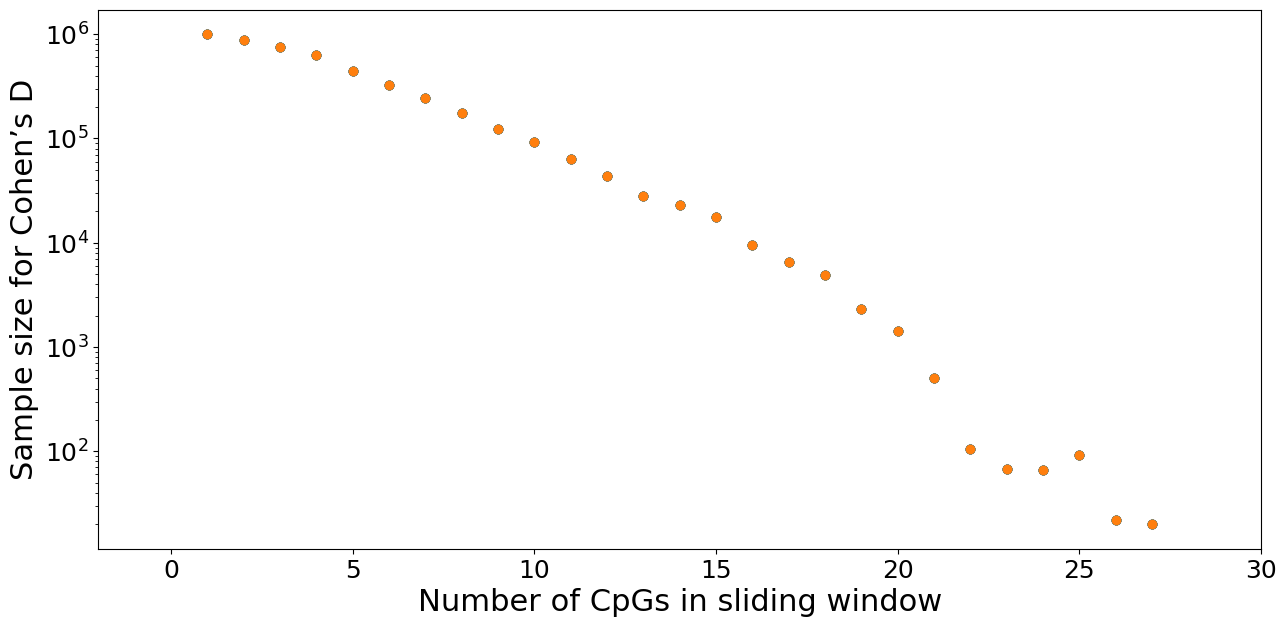

In [19]:
plt.figure(figsize=(15,7))
groups = df_NDR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)

# plt.axhline(y=50)
plt.xlim(-2,30)
# plt.ylim((10**1,10**6))
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

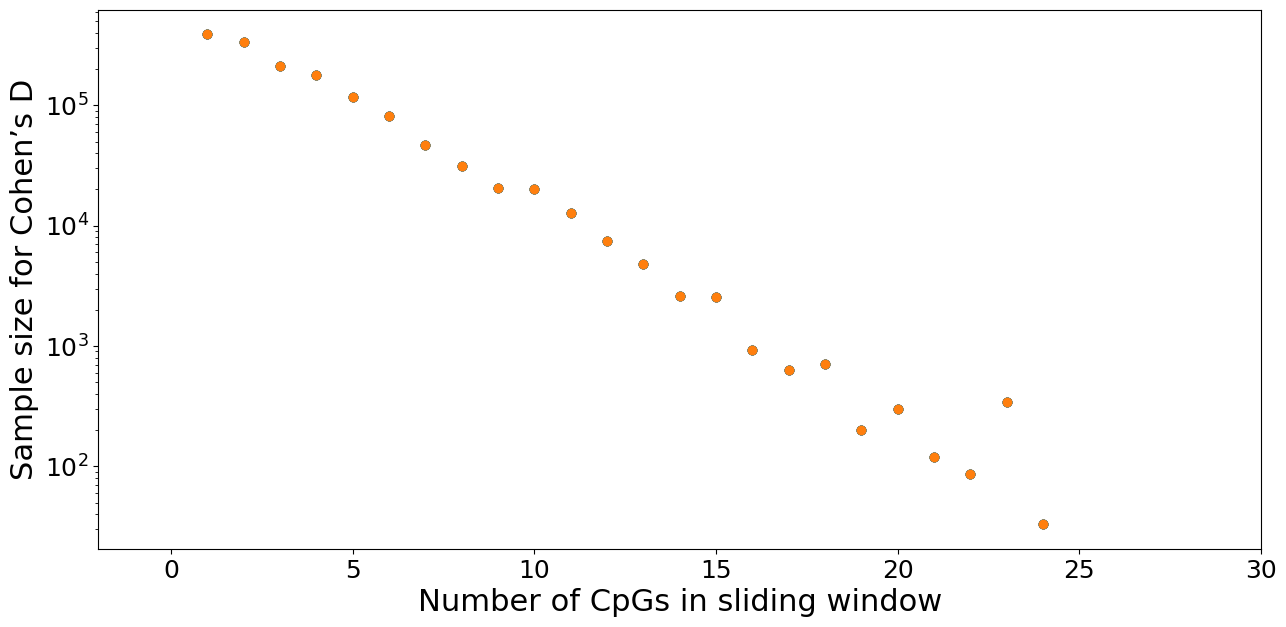

In [20]:
plt.figure(figsize=(15,7))
groups = df_NOR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)
plt.xlim(-2,30)
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

In [28]:
def plot_nbr_CpGs_cohensd(df_values, params):
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))

    for par_name in params:
        
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_cohens_d_vals = list(df_values_tmp["cohens_d"])
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals, y_cohens_d_vals, linestyle="-", color=c, marker=m, markersize=ms, label=par_name)
    
    
    plt.axhline(y=0.2, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.5, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.8, linewidth=1, color = '#2C3E50',linestyle='--')
    
    e = 0.02
    ax.text(-1.8,0.2+e, "Small ES")
    ax.text(-1.8,0.5+e, "Medium ES")
    ax.text(-1.8,0.8+e, "Large ES")

    ax.set_ylabel("Cohen's D", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2,30)
    plt.ylim(-5,5)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="lower left", ncol=4, frameon = 1, prop={'size':18})
    legend.get_frame().set_facecolor('white')

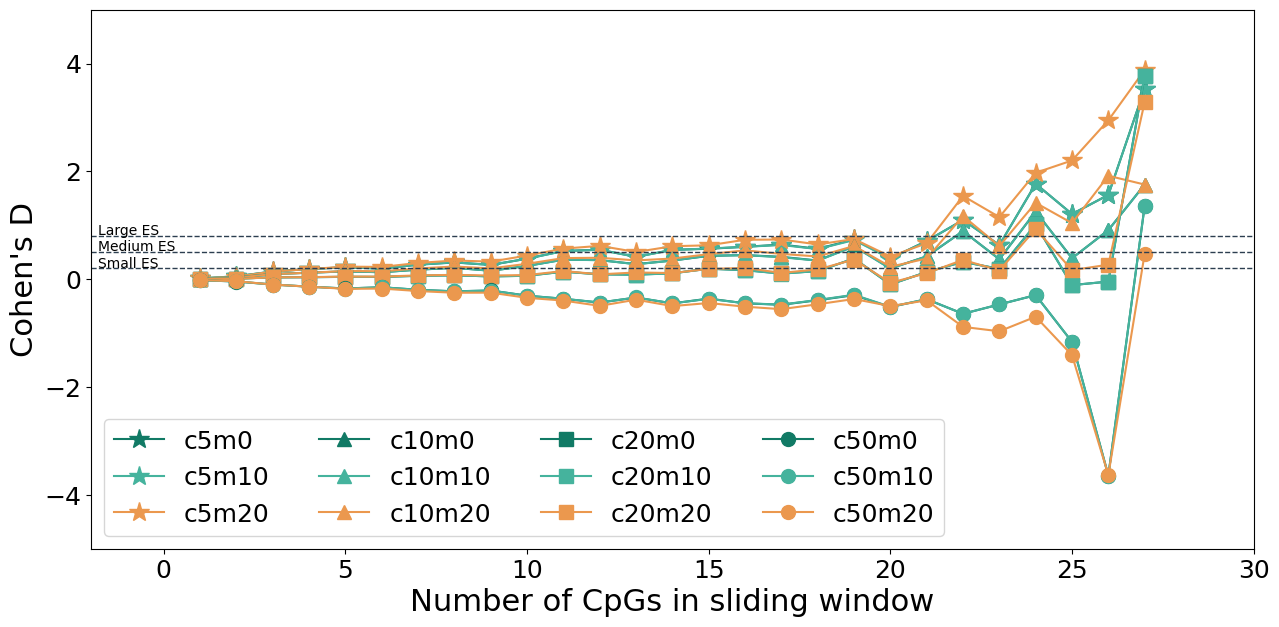

In [29]:
plot_nbr_CpGs_cohensd(df_NDR_pvalues, params)

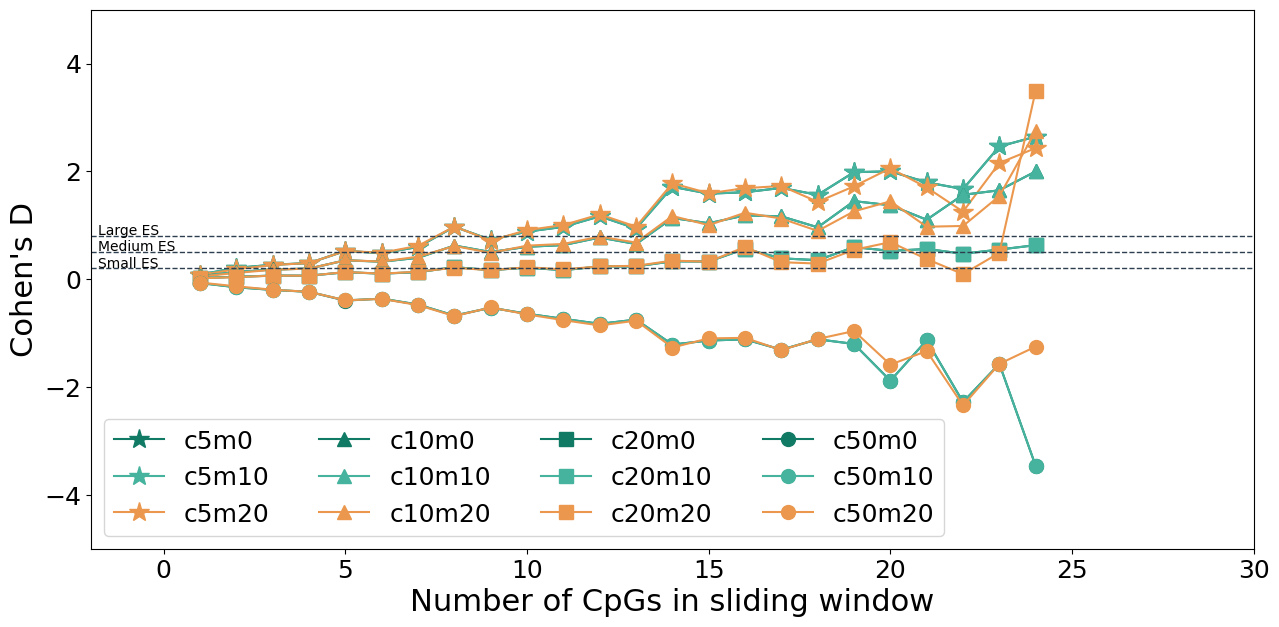

In [30]:
plot_nbr_CpGs_cohensd(df_NOR_pvalues, params)

In [31]:
def plot_pvals_cohensd(df_values,params):
    
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))
    
    for par_name in params:
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_pvals_vals = list(df_values_tmp["pval_ranksums"])
        
        y_pvals_log = [-np.log10(p_val) if p_val != 0.0 else 310 for p_val in y_pvals_vals]
        # print(min([p_val for p_val in y_pvals_vals]))
        # y_pvals_log = [-np.log10(p_val) for p_val in y_pvals_vals]
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals,y_pvals_log,linestyle="-",color=c,marker=m,markersize=ms,label=par_name)
    
    
    #plt.axhline(y=-np.log10(0.05), linewidth=1, color = '#5D6D7E',linestyle='-')
    #plt.axhline(y=-np.log10(0.01), linewidth=1, color = '#515A5A',linestyle='-')

    ax.set_ylabel("-log10(P-value)", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2, 30)
    plt.ylim(0, 450)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="upper right",ncol=4,frameon = 1,prop={'size':18})
    legend.get_frame().set_facecolor('white')

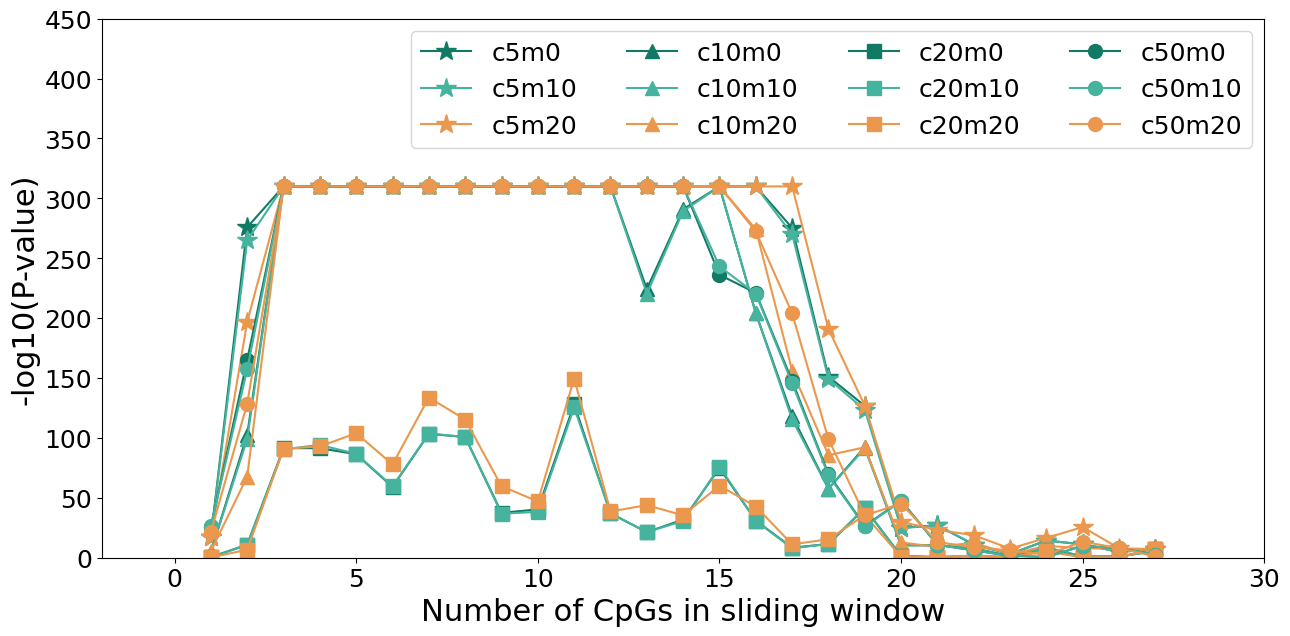

In [32]:
plot_pvals_cohensd(df_NDR_pvalues, params)

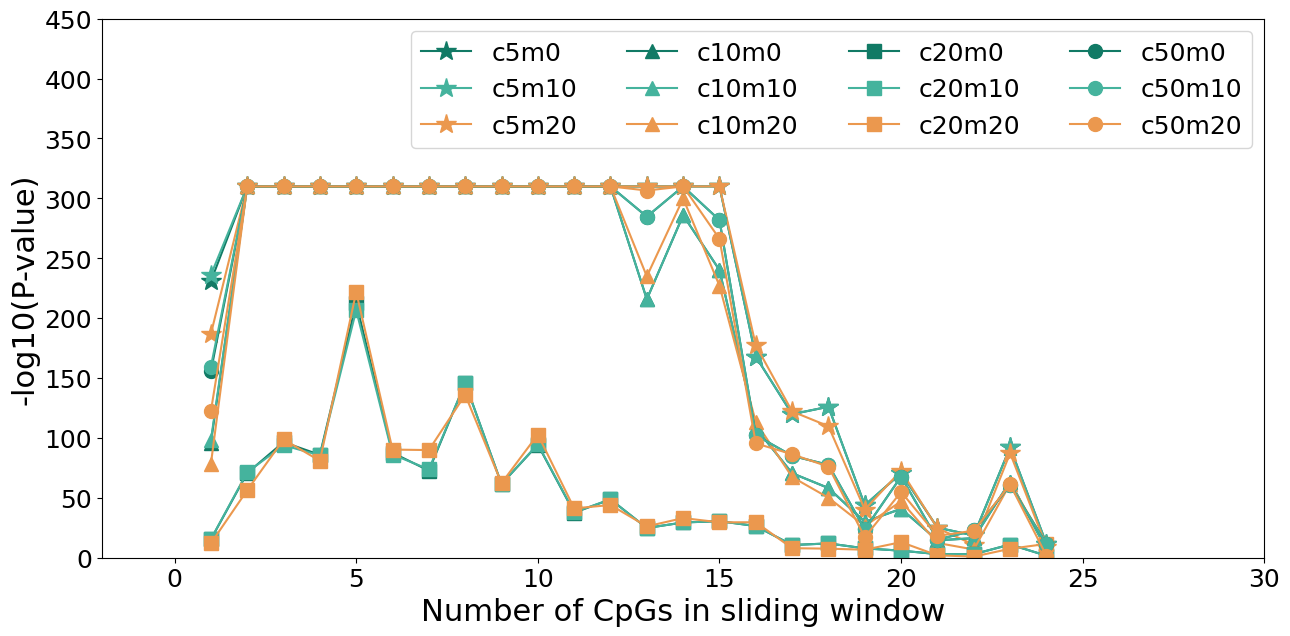

In [33]:
plot_pvals_cohensd(df_NOR_pvalues, params)

#### Cohen's D Calculation Table

In [5]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
    
    df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP['nbr_CpGs'].between(10,20)]
    df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND['nbr_CpGs'].between(10,20)]
                    
    for p in range(len(params)):
        par_name = params[p]
        EXP_scores = list(df_scores_EXP_tmp[par_name])
        RAND_scores = list(df_scores_RAND_tmp[par_name])
        
        # info_dict["nbr_CpGs"].append(nbr_CpGs)
        info_dict["parameter"].append(par_name)
        
        info_dict["N_EXP"].append(len(EXP_scores))
        info_dict["N_RAND"].append(len(RAND_scores))
        
        info_dict["mean_EXP"].append(np.mean(EXP_scores))
        info_dict["median_EXP"].append(np.median(EXP_scores))
        info_dict["std_EXP"].append(np.std(EXP_scores))
        
        info_dict["mean_RAND"].append(np.mean(RAND_scores))
        info_dict["median_RAND"].append(np.median(RAND_scores))
        info_dict["std_RAND"].append(np.std(RAND_scores))
        
        #EFFECT SIZE
        cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
        info_dict["cohens_d"].append(cohens_d)
        
        #STAT TESTS
        #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
        pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
        pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
        
        #students t
        ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
        t_stat = ttest_res[0]
        p_val_ttest = float(ttest_res[1])/2.0
        
        #ranksums, kstest
        ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
        ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]

        info_dict["is_normal_EXP"].append(pval_normal_EXP)
        info_dict["is_normal_RAND"].append(pval_normal_RAND)
        info_dict["pval_ttest"].append(p_val_ttest)
        info_dict["t_stat"].append(t_stat)
        info_dict["pval_ranksums"].append(ranksums)
        info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["parameter"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [37]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
region = 'intron.2.start'

In [38]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [39]:
df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

In [40]:
df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

In [41]:
df_NDR_pvalues

,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,c5m0,78530,78530,0.572438,0.600000,0.183437,0.386070,0.400000,0.138335,1.147163,2.729953e-298,6.413601e-55,0.0,227.314895,0.0,0.0
1,c5m10,78530,78530,0.572538,0.600000,0.183491,0.386120,0.400000,0.138352,1.147204,2.373014e-298,6.641776e-55,0.0,227.322985,0.0,0.0
2,c5m20,78530,78530,0.594482,0.600000,0.185328,0.398592,0.400000,0.140443,1.191363,0.000000e+00,4.915689e-46,0.0,236.073192,0.0,0.0
3,c10m0,78530,78530,0.547395,0.545455,0.162514,0.425085,0.416667,0.140951,0.804053,1.936955e-79,3.607775e-38,0.0,159.326417,0.0,0.0
4,c10m10,78530,78530,0.547461,0.545455,0.162527,0.425116,0.416667,0.140969,0.804204,8.000297e-80,2.246216e-38,0.0,159.356198,0.0,0.0
5,c10m20,78530,78530,0.561630,0.571429,0.162974,0.433306,0.428571,0.143664,0.835310,4.447091e-108,2.202080e-41,0.0,165.520013,0.0,0.0
6,c20m0,78530,78530,0.515884,0.500000,0.146978,0.475168,0.500000,0.143392,0.280421,1.551300e-16,9.677859e-13,0.0,55.566630,0.0,0.0
7,c20m10,78530,78530,0.515910,0.500000,0.146967,0.475171,0.500000,0.143386,0.280597,1.463937e-16,1.041731e-12,0.0,55.601394,0.0,0.0
8,c20m20,78530,78530,0.520208,0.500000,0.145434,0.477919,0.500000,0.146743,0.289465,2.499118e-34,6.686007e-29,0.0,57.358612,0.0,0.0
9,c50m0,78530,78530,0.447568,0.437500,0.166341,0.582143,0.600000,0.142227,-0.869602,1.806947e-124,2.079657e-43,0.0,-172.315126,0.0,0.0


In [42]:
df_NOR_pvalues

,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,c5m0,13220,13220,0.671572,0.700000,0.189026,0.391317,0.400000,0.145999,1.659403,0.000000e+00,5.725544e-18,0.000000e+00,134.908335,0.000000e+00,0.000000e+00
1,c5m10,13220,13220,0.671572,0.700000,0.189026,0.391787,0.400000,0.145676,1.657991,0.000000e+00,2.959632e-18,0.000000e+00,134.793517,0.000000e+00,0.000000e+00
2,c5m20,13220,13220,0.690482,0.714286,0.187871,0.404220,0.400000,0.146917,1.697442,0.000000e+00,4.478300e-29,0.000000e+00,138.000830,0.000000e+00,0.000000e+00
3,c10m0,13220,13220,0.611825,0.615385,0.174104,0.428243,0.416667,0.153182,1.119549,1.739317e-85,6.903520e-10,0.000000e+00,91.018610,0.000000e+00,0.000000e+00
4,c10m10,13220,13220,0.611825,0.615385,0.174104,0.428553,0.416667,0.152914,1.118514,1.739317e-85,1.807112e-09,0.000000e+00,90.934425,0.000000e+00,0.000000e+00
5,c10m20,13220,13220,0.624123,0.636364,0.173537,0.436896,0.428571,0.152540,1.145982,1.020973e-100,8.973506e-14,0.000000e+00,93.167532,0.000000e+00,0.000000e+00
6,c20m0,13220,13220,0.536420,0.538462,0.165539,0.474235,0.500000,0.156932,0.385540,6.704730e-11,4.077464e-04,4.504535e-212,31.344161,1.750685e-199,3.489041e-138
7,c20m10,13220,13220,0.536420,0.538462,0.165539,0.474345,0.500000,0.156591,0.385253,6.704730e-11,1.122575e-03,9.141665e-212,31.320823,2.188592e-199,2.854108e-139
8,c20m20,13220,13220,0.540900,0.538462,0.165551,0.477610,0.500000,0.153520,0.396428,3.338962e-16,6.748918e-01,7.686003e-224,32.229313,8.574915e-211,6.058908e-154
9,c50m0,13220,13220,0.374507,0.363636,0.176027,0.579782,0.600000,0.152417,-1.246756,4.677340e-120,4.481370e-18,0.000000e+00,-101.360434,0.000000e+00,0.000000e+00


In [6]:
regions = ['promoter', 'intron.1.start', 'intron.1.end', 'intron.2.start']
labels = ['promoter', 'start of 1st intron', 'end of 1st intron', 'start of 2nd intron']
table = {}
for label, region in zip(labels, regions):
    print(region)
    df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
    df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
    df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
    df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

    df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)
    df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

    assert df_NDR_pvalues.shape[0] == df_NOR_pvalues.shape[0]
    assert df_NDR_pvalues['parameter'].to_list() == df_NOR_pvalues['parameter'].to_list()

    table[label] = {
        'Parameter': df_NDR_pvalues['parameter'].to_list(),
        'HNDRs': df_NOR_pvalues['cohens_d'].to_list(),
        'LNDRs': df_NDR_pvalues['cohens_d'].to_list()
    }

promoter
intron.1.start
intron.1.end
intron.2.start


In [7]:
print(pd.DataFrame(table).T.explode(['Parameter', 'LNDRs', 'HNDRs']).to_latex(float_format="{:.2f}".format))

\begin{tabular}{llll}
\toprule
{} & Parameter & HNDRs & LNDRs \\
\midrule
promoter            &      c5m0 &  1.03 &  0.48 \\
promoter            &     c5m10 &  1.03 &  0.48 \\
promoter            &     c5m20 &  1.06 &  0.54 \\
promoter            &     c10m0 &  0.69 &  0.32 \\
promoter            &    c10m10 &  0.69 &  0.32 \\
promoter            &    c10m20 &  0.71 &  0.36 \\
promoter            &     c20m0 &  0.23 &  0.10 \\
promoter            &    c20m10 &  0.23 &  0.10 \\
promoter            &    c20m20 &  0.23 &  0.12 \\
promoter            &     c50m0 & -0.76 & -0.36 \\
promoter            &    c50m10 & -0.76 & -0.36 \\
promoter            &    c50m20 & -0.77 & -0.41 \\
start of 1st intron &      c5m0 &  1.46 &  0.78 \\
start of 1st intron &     c5m10 &  1.45 &  0.78 \\
start of 1st intron &     c5m20 &  1.50 &  0.85 \\
start of 1st intron &     c10m0 &  0.99 &  0.53 \\
start of 1st intron &    c10m10 &  0.99 &  0.53 \\
start of 1st intron &    c10m20 &  1.03 &  0.57 \\
start of

/tmp/ipykernel_3630891/18143195.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(table).T.explode(['Parameter', 'LNDRs', 'HNDRs']).to_latex(float_format="{:.2f}".format))


#### Histograms

In [6]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [7]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [8]:
df_NDR_score_exp.columns

Index(['refid_NOR', 'trans_id', 'refid', 'NOR_nbr', 'window_nbr', 'nbr_CpGs',
       'nuc_rel_center', 'nuc_region_length', 'c5m0', 'c5m10', 'c5m20',
       'c10m0', 'c10m10', 'c10m20', 'c20m0', 'c20m10', 'c20m20', 'c50m0',
       'c50m10', 'c50m20'],
      dtype='object')

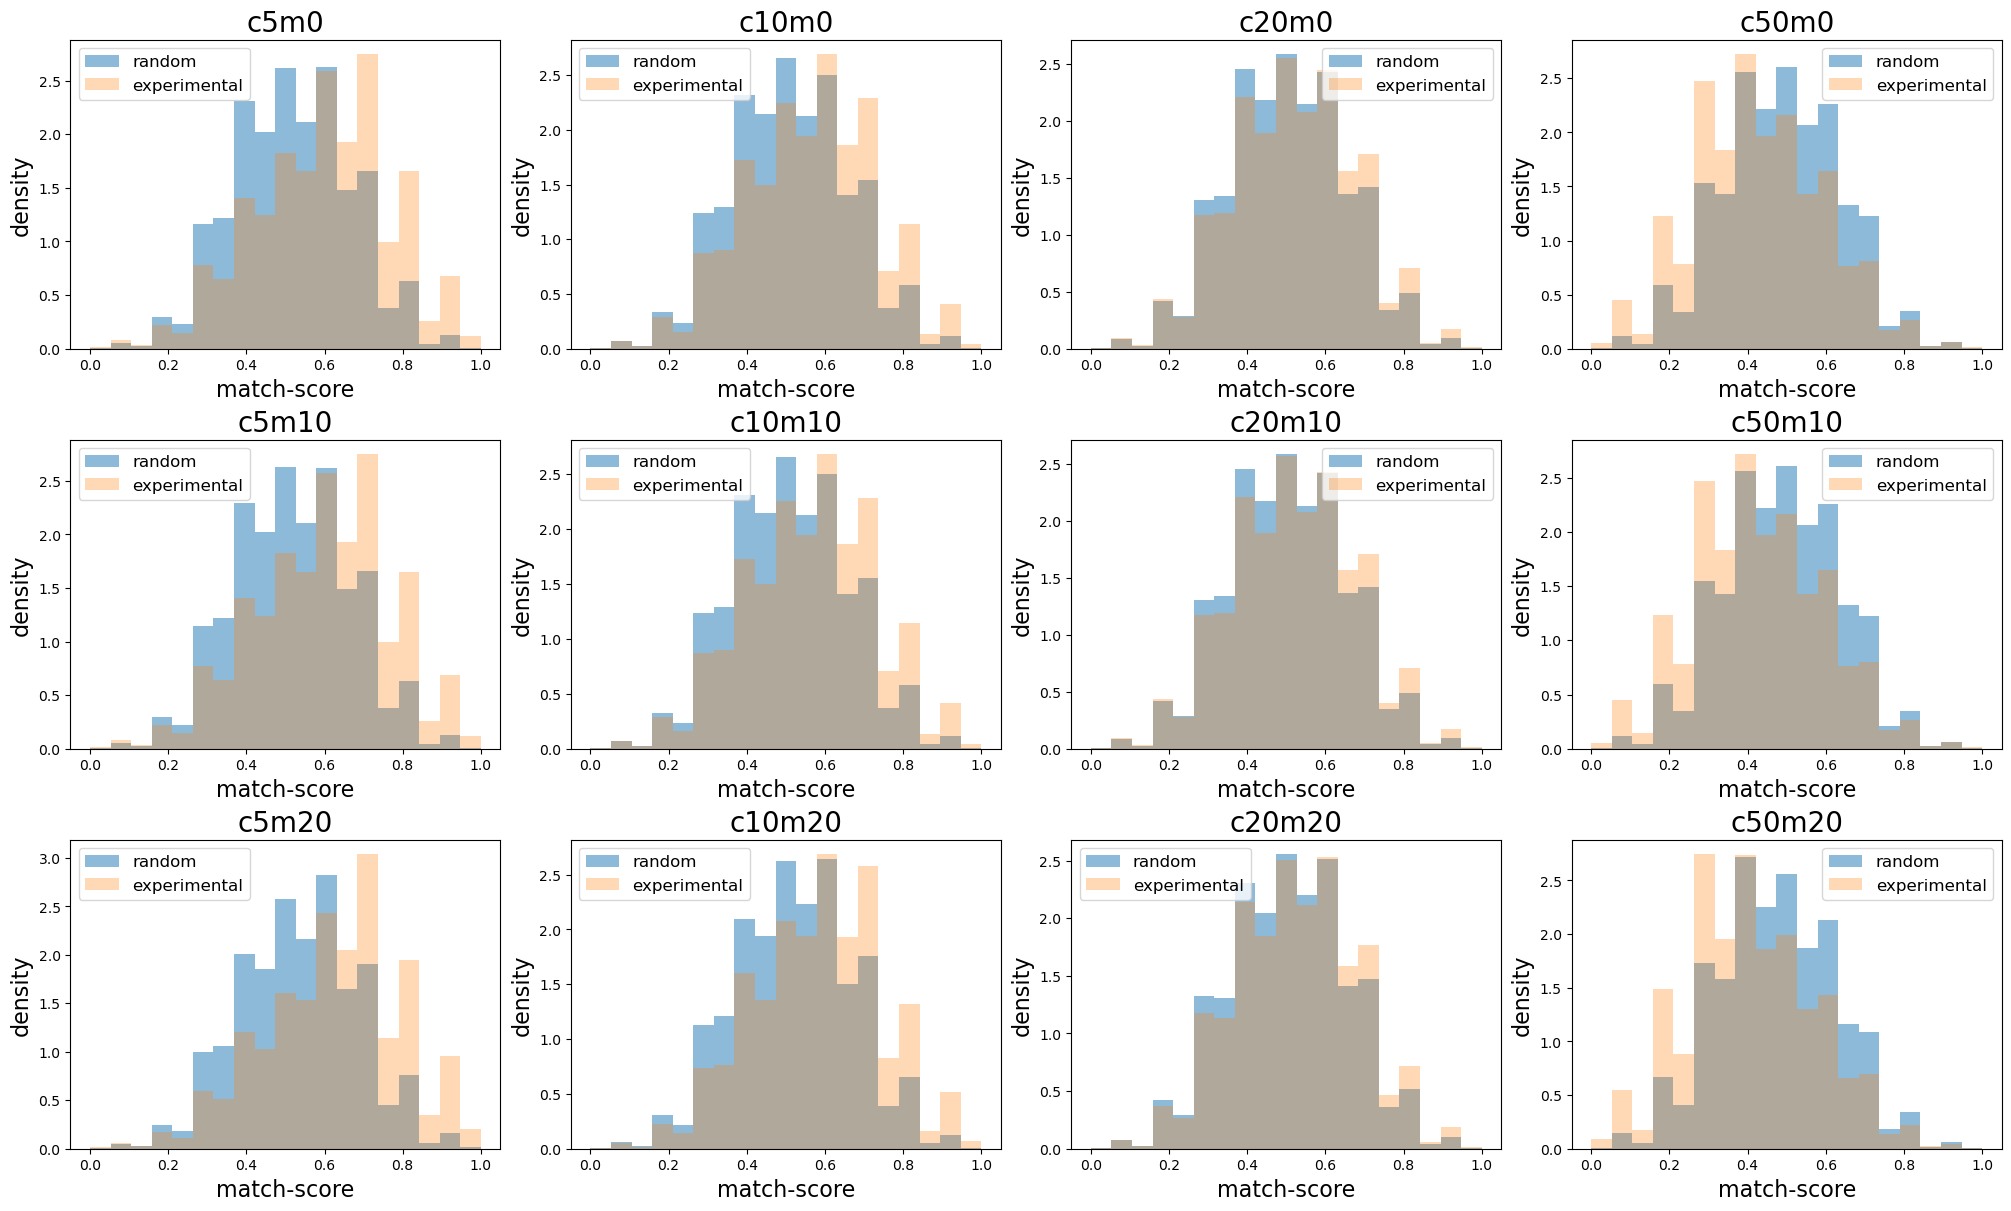

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NDR_score_random.loc[df_NDR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NDR_score_exp.loc[df_NDR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)

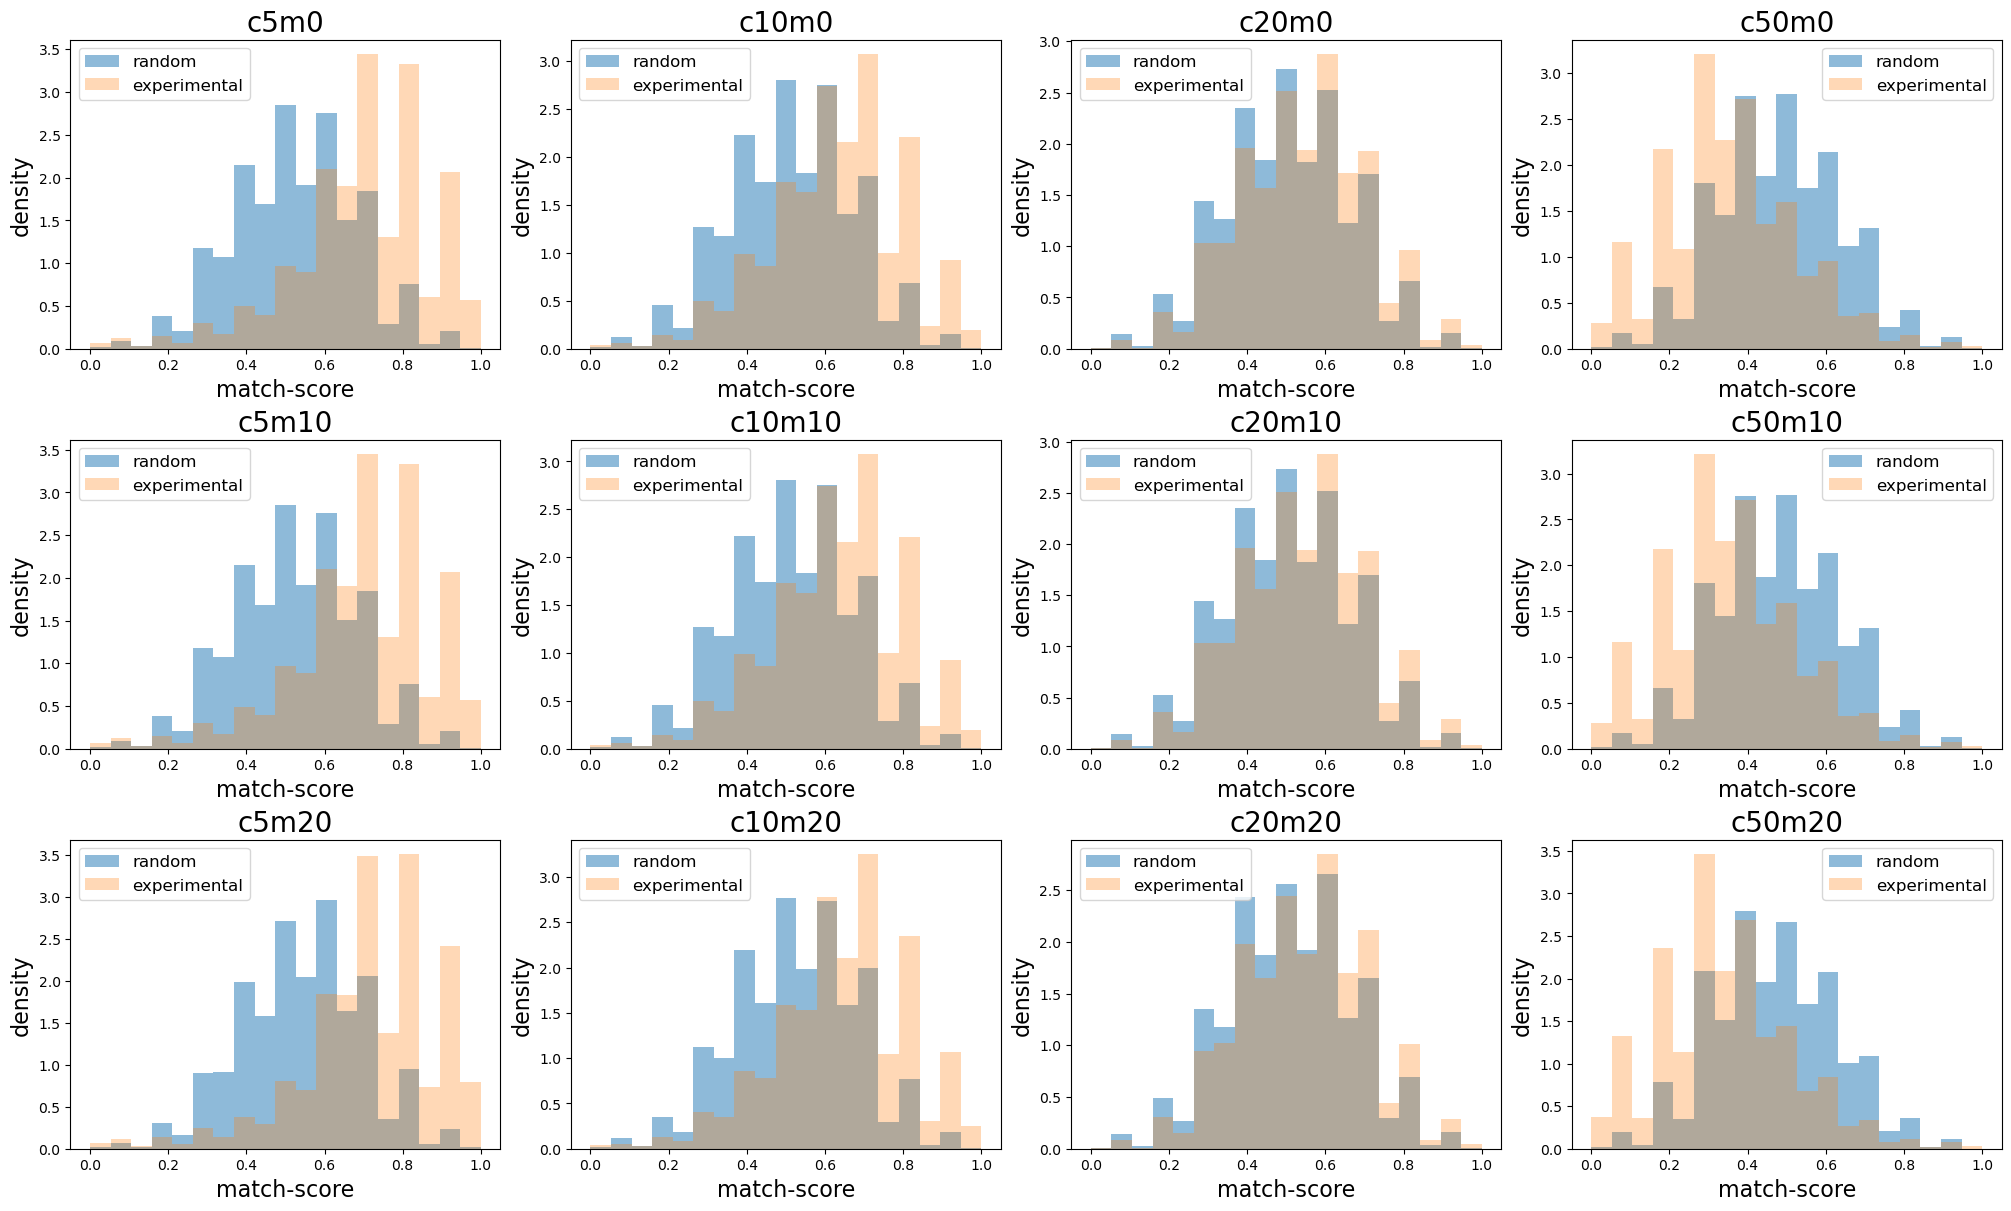

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NOR_score_random.loc[df_NOR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NOR_score_exp.loc[df_NOR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)